In [50]:
import glob 
import sys 
sys.path.append('..')
from print_results import get_stats
import matplotlib.pyplot as plt 
import numpy as np 

In [51]:
to_search = {
    'lanl': {
        'static': '../results/rw/lanl14argus/snapshot-ft_results_snapshot_bert_static*.txt', 
        'temporal': '../results/trw/lanl14argus/snapshot-ft_results_snapshot_bert*.txt'
    }, 
    'unsw': {
        'static': '../results/rw/unsw/snapshot-ft_results_snapshot_bert_static*.txt', 
        'temporal': '../results/trw/unsw/snapshot-ft_results_snapshot_bert*.txt'
    },
    'optc': { # Stupidly used a different naming convention for CLS finetuning
        'static': '../results/ft/optc/static_results_snapshot_bert*.txt', 
        'temporal': '../results/ft/optc/rwft_results_snapshot_bert*.txt', 
    },
    'optc-gfm': { # Can't really define how well an untrained cls model does, but can compare to 
                  # non-finetuned LP models did 
        'static': '../results/rw/optc/snapshot-ft_results_snapshot_bert_static*.txt', 
        'temporal': '../results/trw/optc/snapshot-ft_results_snapshot_bert*.txt'

    }
}

best = dict() 
results = dict() 
for dataset,temporal_map in to_search.items(): 
    results[dataset] = dict()
    
    for isTemporal,search in temporal_map.items(): 
        nft,auc,ap = get_stats(glob.glob(search))
        results[dataset][isTemporal] = {
            'finetuned': auc[['tiny_auc', 'tiny_ap']].sort_index(inplace=False),
            'base': nft[['tiny_auc', 'tiny_ap']].sort_index(inplace=False)
        }

        best_wl = auc.idxmax(skipna=True)['tiny_ap']
        
        best[f'{dataset}-{isTemporal[0].upper()}'] = (
            auc.loc[best_wl, 'tiny_auc'], 
            auc.loc[best_wl, 'tiny_ap']
        )

import json 
print(json.dumps(best, indent=1))

{
 "lanl-S": [
  0.9971868639311527,
  0.3585815464735521
 ],
 "lanl-T": [
  0.9944123934921628,
  0.19846642657195762
 ],
 "unsw-S": [
  0.9938543139183659,
  0.9918617379042277
 ],
 "unsw-T": [
  0.9951782048399277,
  0.9937561565223243
 ],
 "optc-S": [
  0.9877201975605931,
  0.9025106612763546
 ],
 "optc-T": [
  0.9810463016365217,
  0.8835115608050729
 ],
 "optc-gfm-S": [
  0.8789479182309584,
  0.4470506748976601
 ],
 "optc-gfm-T": [
  0.9180279475503592,
  0.4122754439459259
 ]
}


/tmp/ipykernel_2596646/1314134288.py:34: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_wl = auc.idxmax(skipna=True)['tiny_ap']
/tmp/ipykernel_2596646/1314134288.py:34: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_wl = auc.idxmax(skipna=True)['tiny_ap']
/tmp/ipykernel_2596646/1314134288.py:34: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_wl = auc.idxmax(skipna=True)['tiny_ap']
/tmp/ipykernel_2596646/1314134288.py:34: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_wl = auc.idxmax(skipna=True)['tiny_ap']
/tmp/ipykernel_2

[[0.36575247 0.44705067]
 [0.48207036 0.41227544]
 [0.96599737 0.99186174]
 [0.70264544 0.99375616]
 [0.07225416 0.35858155]
 [0.0073923  0.19846643]]


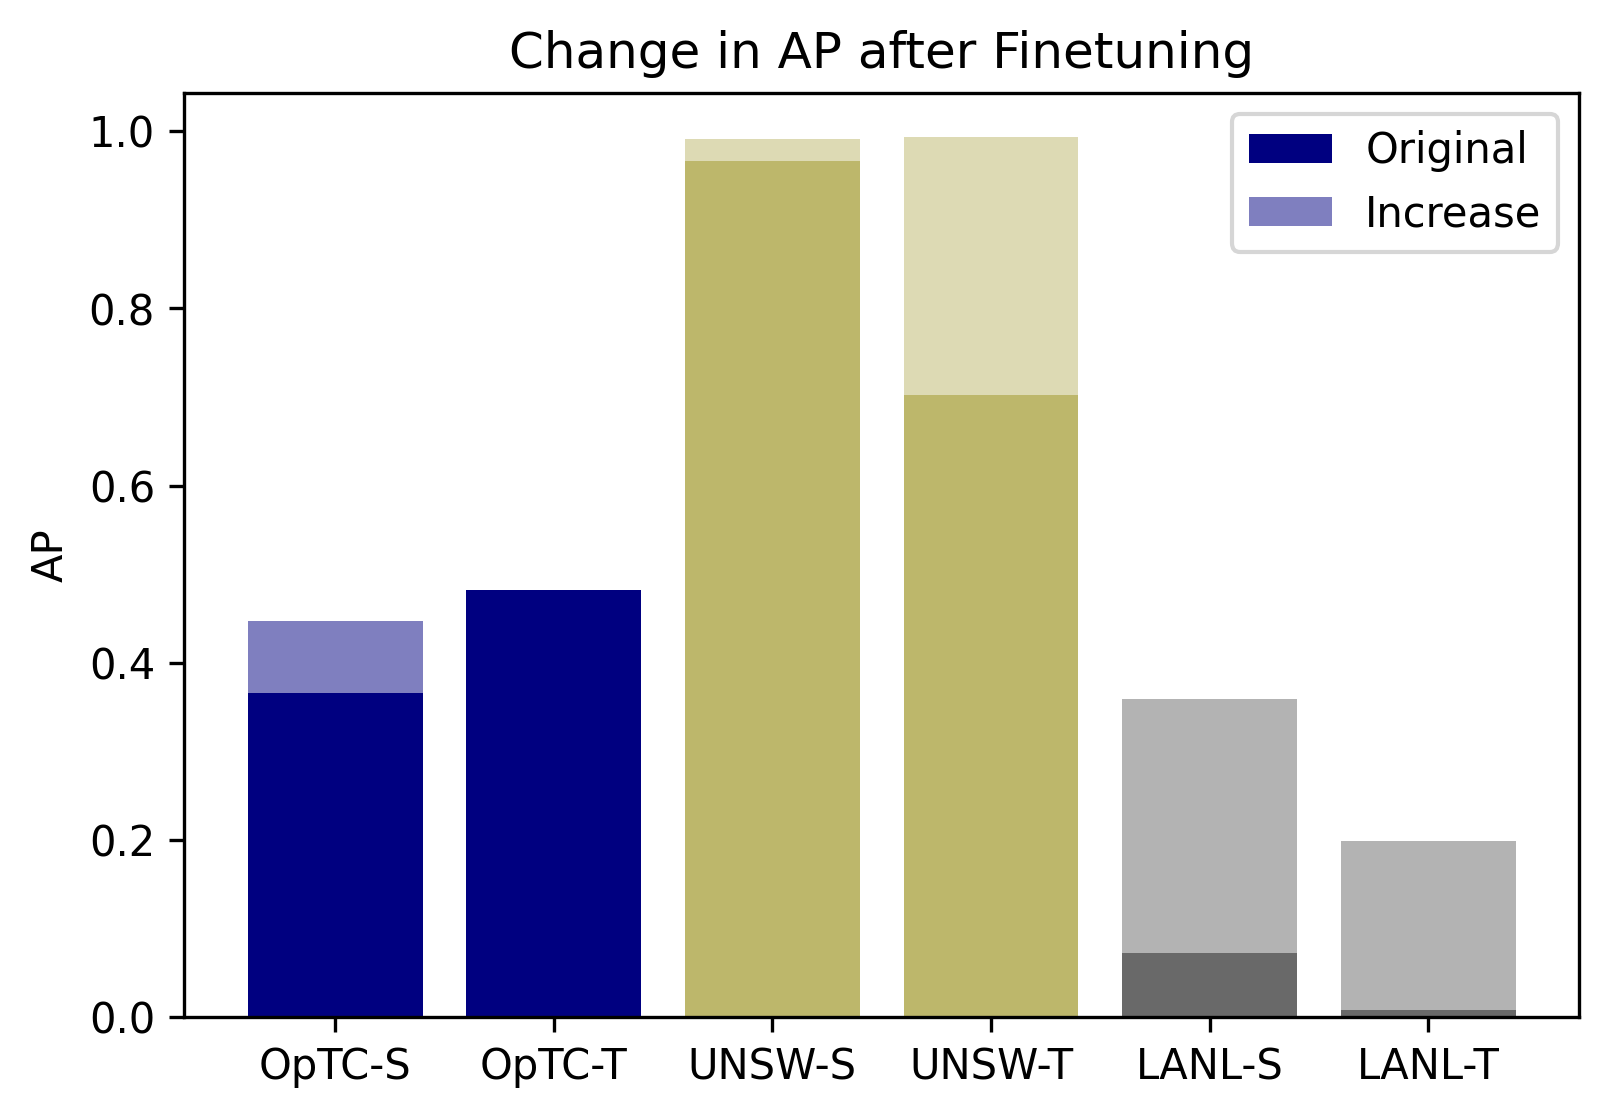

In [52]:
before_after = []
labels = []

dataset = 'lanl'
temp = 'static'

label_map = {
    'optc-gfm': 'OpTC',
    'optc': 'OpTC',
    'unsw': 'UNSW', 
    'lanl': 'LANL', 
    'static': 'S',
    'temporal': 'T'
}

for dataset in ['optc-gfm', 'unsw', 'lanl']: 
    for temp in ['static', 'temporal']:
        dfs = results[dataset][temp]
        best_wl = dfs['finetuned'].idxmax()['tiny_ap']
        ft_ap = dfs['finetuned'].loc[best_wl, 'tiny_ap']

        #if dataset != 'optc': 
        #    gfm_ap = dfs['base'].loc[best_wl, 'tiny_ap']
        #else: 
        #    gfm_ap = results['optc-gfm'][temp]['base'].loc[best_wl, 'tiny_ap']
        gfm_ap = dfs['base'].loc[best_wl, 'tiny_ap']
        
        before_after.append([gfm_ap, ft_ap])
        labels.append(f'{label_map[dataset]}-{label_map[temp]}')

data = np.array(before_after)
original = data[:, 0]
new = data[:, 1]

colors = ['navy', 'navy', 'darkkhaki', 'darkkhaki', 'dimgray', 'dimgray']

# Create x positions
x = np.arange(len(data))

plt.figure(figsize=(6, 4), dpi=300)

# Plot stacked bars
plt.bar(x, original, label="Original", color=colors)
plt.bar(x, new - original, bottom=original, label="Increase", color=colors, alpha=0.5)

# Format chart
plt.xticks(x, labels)
plt.ylabel("AP")
plt.title("Change in AP after Finetuning")
plt.legend()

print(data)

plt.show()

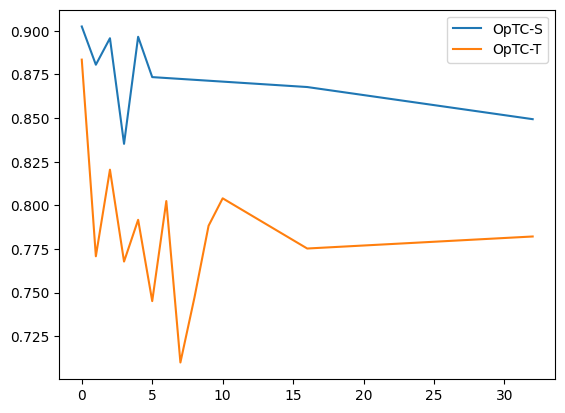

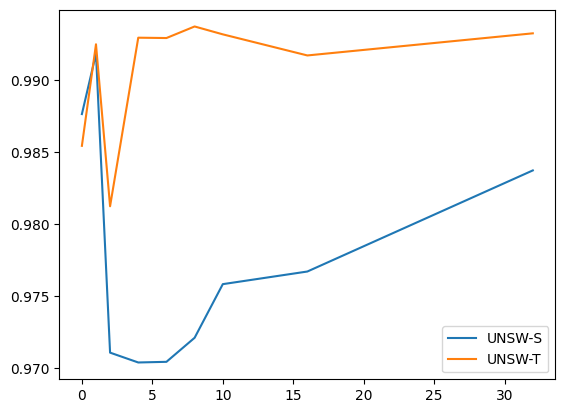

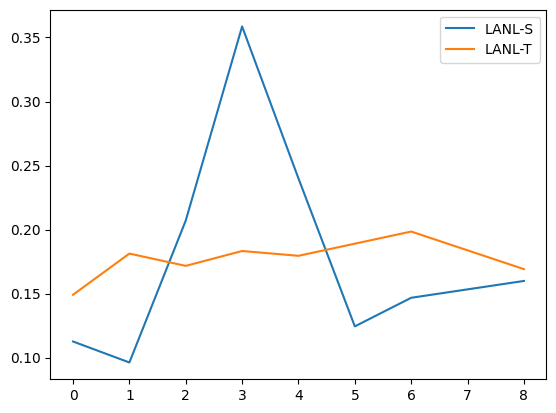

In [53]:
walk_to_ap = []
labels = []

for dataset in ['optc', 'unsw', 'lanl']: 
    for temp in ['static', 'temporal']: 
        df = results[dataset][temp]['finetuned']
        wta = df.reset_index()[['index', 'tiny_ap']].to_numpy()
        wta = wta[wta[:,1] != 0]
        
        walk_to_ap.append(wta)
        labels.append(f'{label_map[dataset]}-{label_map[temp]}')

    for i in range(len(walk_to_ap)): 
        wta = walk_to_ap[i]
        label = labels[i]

        plt.plot(wta[:,0], wta[:,1], label=label)

    walk_to_ap = []
    labels = []

    plt.legend() 
    plt.show()

[[0.         0.90251066]
 [0.         0.88351156]
 [0.84346793 0.99186174]
 [0.         0.99375616]
 [0.12615879 0.35858155]
 [0.         0.19846643]]


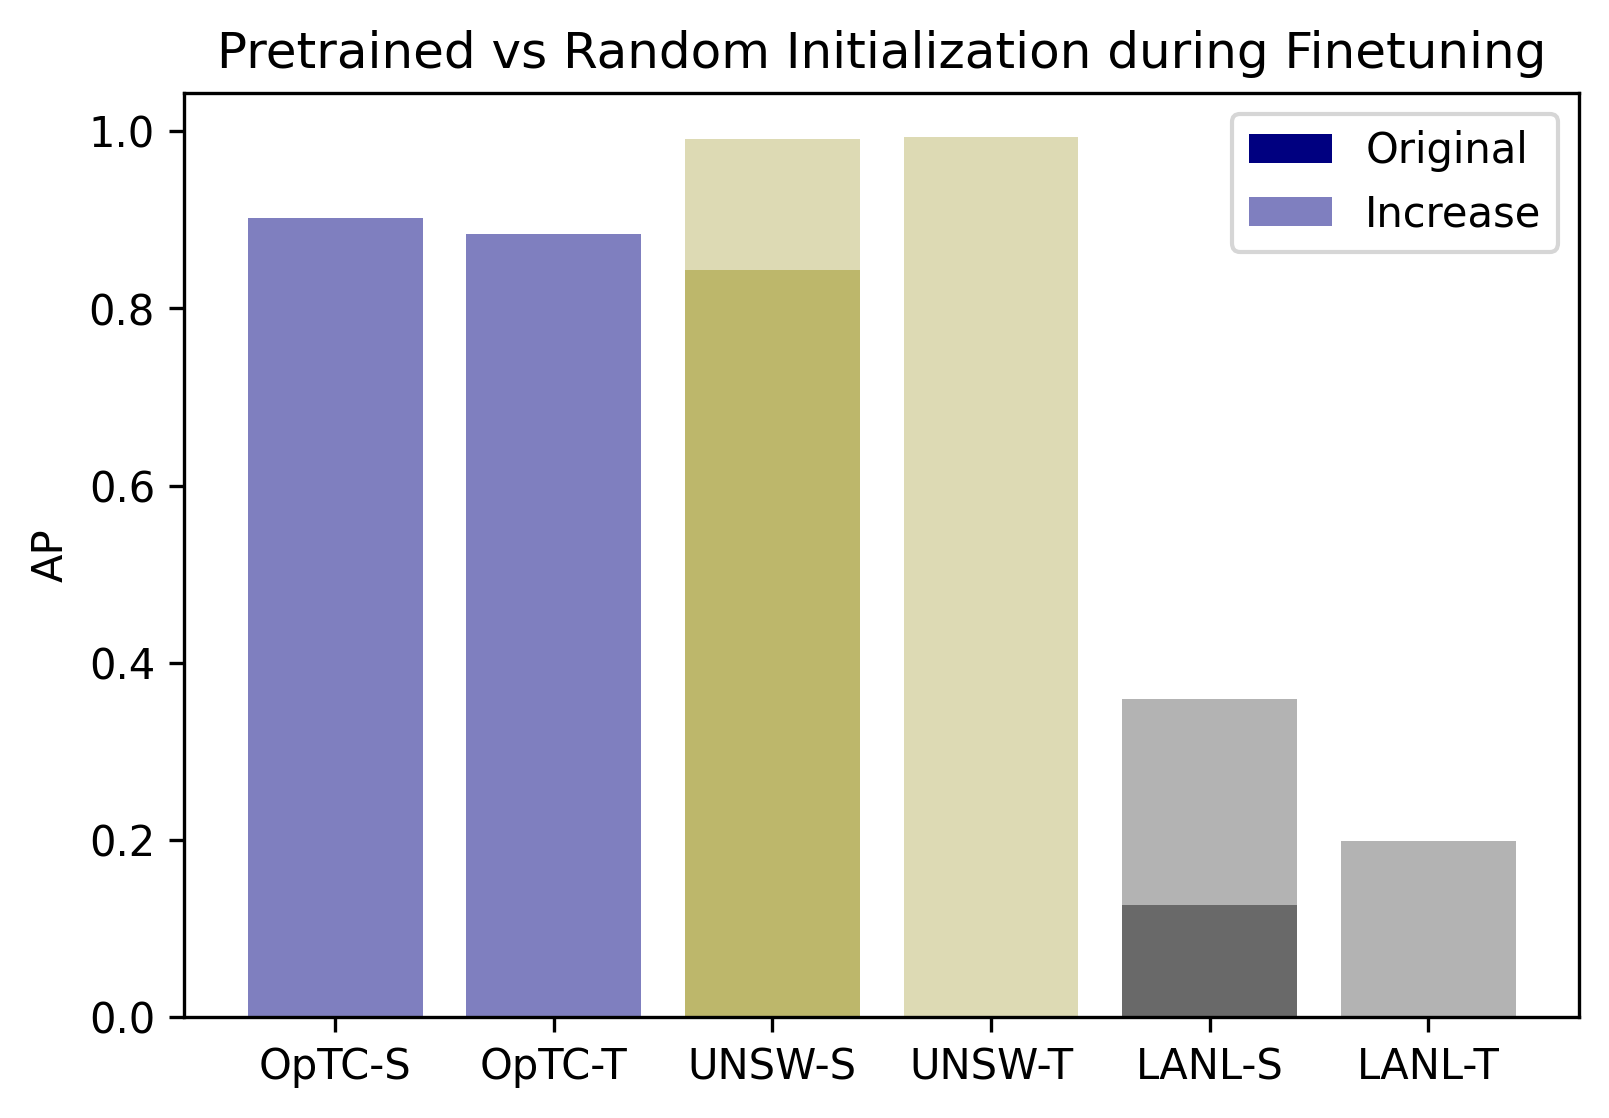

In [54]:
dmap = dict() 

from_scratch_files = glob.glob('../results/**/**/*_rand_init_*')
for f in from_scratch_files:
    nft,auc,ap = get_stats([f])
    auc = auc[['tiny_ap', 'tiny_auc']]
    best_rnd = auc.loc[auc.idxmax(skipna=True)['tiny_ap']]
    auc,ap = best_rnd['tiny_auc'], best_rnd['tiny_ap']
    
    dataset = f.split('/')[3]

    if dataset != 'optc': 
        t = 'S' if f.split('/')[2] == 'rw' else 'T'
    else: 
        t = 'S' if f.split('/')[-1].startswith('static') else 'T'

    dmap[dataset[:4]+'-'+t] = ap 

bars = []
labels = []
for dataset in ['optc', 'unsw', 'lanl']:
    for t in ['S', 'T']: 
        k = f'{dataset}-{t}'
    
        try: 
            rnd = dmap[k]
        except: 
            rnd = 0 
        
        ft = best[k][1]
        bars.append([rnd,ft])

        # Hacky way to make it display as OpTC
        labels.append(k.upper().replace('P', 'p'))


data = np.array(bars)
original = data[:, 0]
new = data[:, 1]

colors = ['navy', 'navy', 'darkkhaki', 'darkkhaki', 'dimgray', 'dimgray']

# Create x positions
x = np.arange(len(data))

plt.figure(figsize=(6, 4), dpi=300)

# Plot stacked bars
plt.bar(x, original, label="Original", color=colors)
plt.bar(x, new - original, bottom=original, label="Increase", color=colors, alpha=0.5)

# Format chart
plt.xticks(x, labels)
plt.ylabel("AP")
plt.title("Pretrained vs Random Initialization during Finetuning")
plt.legend()

print(data)

plt.show()